<a href="https://colab.research.google.com/github/yasaswini-manam/Traffic-Volume-Prediction/blob/main/traffic_volume_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Load dataset
df = pd.read_csv("/content/Metro_Interstate_Traffic_Volume.csv")

# Step 1: Convert 'date_time' to datetime
df['date_time'] = pd.to_datetime(df['date_time'])

# Step 2: Check and show missing values
print("Missing values per column:")
print(df.isnull().sum())

# Step 3: Encode categorical features
le_holiday = LabelEncoder()
le_weather_main = LabelEncoder()
le_weather_desc = LabelEncoder()

df['holiday'] = le_holiday.fit_transform(df['holiday'])
df['weather_main'] = le_weather_main.fit_transform(df['weather_main'])
df['weather_description'] = le_weather_desc.fit_transform(df['weather_description'])

# Step 4: Scale numerical features
scaler = MinMaxScaler()
numerical_features = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Preview the processed dataset
print("\nPreprocessed Data Sample:")
print(df.head())


Missing values per column:
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume             0
dtype: int64

Preprocessed Data Sample:
   holiday      temp  rain_1h  snow_1h  clouds_all  weather_main  \
0       11  0.929726      0.0      0.0        0.40             1   
1       11  0.933209      0.0      0.0        0.75             1   
2       11  0.933918      0.0      0.0        0.90             1   
3       11  0.935692      0.0      0.0        0.90             1   
4       11  0.938949      0.0      0.0        0.75             1   

   weather_description           date_time  traffic_volume  
0                   24 2012-10-02 09:00:00            5545  
1                    2 2012-10-02 10:00:00            4516  
2                   19 2012-10-02 11:00:00            4767  
3                  

In [ ]:
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from collections import Counter

# Step 1: Bin traffic_volume into 3 classes
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['traffic_class'] = kbins.fit_transform(df[['traffic_volume']]).astype(int)

# Check class distribution
print("Class distribution before balancing:", Counter(df['traffic_class']))

# Step 2: Separate features and target
X = df.drop(columns=['traffic_volume', 'date_time', 'traffic_class'])
y = df['traffic_class']

# Step 3: Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Check new class distribution
print("Class distribution after SMOTE:", Counter(y_balanced))

# Optional: Re-attach balanced data
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['traffic_class'] = y_balanced




Class distribution before balancing: Counter({2: 16072, 1: 16066, 0: 16066})
Class distribution after SMOTE: Counter({2: 16072, 1: 16072, 0: 16072})


In [ ]:
import pandas as pd
from scipy.stats import zscore

# Assuming df['date_time'] is already converted to datetime

# --- Datetime Feature Extraction ---
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)

# --- Outlier Removal using Z-Score ---
# Compute z-score for 'traffic_volume' and filter
z_scores = zscore(df['traffic_volume'])
df = df[(z_scores < 3) & (z_scores > -3)]

# Check result
print("After outlier removal:", df.shape)
print(df[['traffic_volume', 'hour', 'dayofweek', 'month', 'is_weekend']].head())


After outlier removal: (48204, 14)
   traffic_volume  hour  dayofweek  month  is_weekend
0            5545     9          1     10           0
1            4516    10          1     10           0
2            4767    11          1     10           0
3            5026    12          1     10           0
4            4918    13          1     10           0


In [ ]:
from scipy.fft import fft

# Apply FFT on traffic_volume
traffic_fft = fft(df['traffic_volume'].values)
fft_magnitude = np.abs(traffic_fft)

# Take Top Frequencies
top_k = 10
top_indices = np.argsort(fft_magnitude)[-top_k:]

# Add Top Fourier Components as Features
for idx, freq_idx in enumerate(top_indices):
    df[f'fft_component_{idx}'] = np.real(traffic_fft[freq_idx])
print(df[['fft_component_0', 'fft_component_1', 'fft_component_2']].head())

    fft_component_0  fft_component_1  fft_component_2
6     -3.029694e+06     3.865875e+06     3.865875e+06
7     -3.029694e+06     3.865875e+06     3.865875e+06
8     -3.029694e+06     3.865875e+06     3.865875e+06
9     -3.029694e+06     3.865875e+06     3.865875e+06
10    -3.029694e+06     3.865875e+06     3.865875e+06


In [ ]:
# 2.1 Hourly % Change
df['traffic_pct_change_hour'] = df['traffic_volume'].pct_change(periods=1)

# 2.2 Daily % Change (24-hour)
df['traffic_pct_change_day'] = df['traffic_volume'].pct_change(periods=24)

print(df[['traffic_volume', 'traffic_pct_change_hour', 'traffic_pct_change_day']].head(10))


    traffic_volume  traffic_pct_change_hour  traffic_pct_change_day
6             5584                      NaN                     NaN
7             6015                 0.077185                     NaN
8             5791                -0.037240                     NaN
9             4770                -0.176308                     NaN
10            3539                -0.258071                     NaN
11            2784                -0.213337                     NaN
12            2361                -0.151940                     NaN
13            1529                -0.352393                     NaN
14             963                -0.370177                     NaN
15             506                -0.474559                     NaN


In [ ]:
# 4.1 Assume Holidays
holidays = pd.to_datetime(['2023-01-01', '2023-01-15'])

# 4.2 Find Nearest Holidays
df['days_since_holiday'] = df['date_time'].apply(lambda x: (x - holidays[holidays <= x].max()).days if any(holidays <= x) else np.nan)
df['days_until_holiday'] = df['date_time'].apply(lambda x: (holidays[holidays >= x].min() - x).days if any(holidays >= x) else np.nan)

print(df[['date_time', 'days_since_holiday', 'days_until_holiday']].head(30))


             date_time  days_since_holiday  days_until_holiday
6  2012-10-02 15:00:00                 NaN                3742
7  2012-10-02 16:00:00                 NaN                3742
8  2012-10-02 17:00:00                 NaN                3742
9  2012-10-02 18:00:00                 NaN                3742
10 2012-10-02 19:00:00                 NaN                3742
11 2012-10-02 20:00:00                 NaN                3742
12 2012-10-02 21:00:00                 NaN                3742
13 2012-10-02 22:00:00                 NaN                3742
14 2012-10-02 23:00:00                 NaN                3742
15 2012-10-03 00:00:00                 NaN                3742
16 2012-10-03 01:00:00                 NaN                3741
17 2012-10-03 02:00:00                 NaN                3741
18 2012-10-03 03:00:00                 NaN                3741
19 2012-10-03 04:00:00                 NaN                3741
20 2012-10-03 05:00:00                 NaN             

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

# ----------- Assuming you already have your 'df' created here -----------

# Features and Target
X = df.drop(columns=['traffic_volume', 'date_time'])
y = df['traffic_volume']

# 💥 Fix: Replace inf and very large values with NaN, then fill NaN
X = X.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
X = X.fillna(0)  # Now fill NaN with 0

# Convert X and y to NumPy arrays before passing to XGBoost
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)


# # ----------------- 1. Linear Regression -----------------
# lr_model = LinearRegression()
# lr_model.fit(X_train, y_train)
# lr_pred = lr_model.predict(X_test)
# print("Linear Regression:")
# print("MSE:", mean_squared_error(y_test, lr_pred))
# print("R² Score:", r2_score(y_test, lr_pred))
# print()

# ----------------- 2. XGBoost Regressor -----------------
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
print("XGBoost Regressor:")
print("MSE:", mean_squared_error(y_test, xgb_pred))
print("R² Score:", r2_score(y_test, xgb_pred))
print()

# ----------------- 3. Random Forest Regressor -----------------
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest Regressor:")
print("MSE:", mean_squared_error(y_test, rf_pred))
print("R² Score:", r2_score(y_test, rf_pred))
print()

# ----------------- 4. Logistic Regression (Optional for Classification) -----------------
# Now classify high/low traffic based on median split
y_class = (df['traffic_volume'] > df['traffic_volume'].median()).astype(int)

# New train-test split for classification
# Convert to NumPy arrays for consistency
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X.values, y_class.values, test_size=0.2, random_state=42
)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_class, y_train_class)
log_pred = log_model.predict(X_test_class)
print("Logistic Regression (Classification):")
print("Accuracy:", accuracy_score(y_test_class, log_pred))

Linear Regression:
MSE: 109618.7751244861
R² Score: 0.9724872445241444

XGBoost Regressor:
MSE: 4087.680908203125
R² Score: 0.9989740252494812

Random Forest Regressor:
MSE: 3560.736166815353
R² Score: 0.9991063058006224

Logistic Regression (Classification):
Accuracy: 0.9717842323651452


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# --- Step 1: Bin traffic_volume into 3 classes ---
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['traffic_class'] = kbins.fit_transform(df[['traffic_volume']]).astype(int)

# --- Step 2: Features & Target ---
X = df.drop(columns=['traffic_volume', 'traffic_class', 'date_time'])
y = df['traffic_class']

# --- Step 3: Train-test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Logistic Regression -------------------
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)
log_acc = accuracy_score(y_test, log_pred)
print("🔹 Logistic Regression Accuracy:", log_acc)

# ------------------- Random Forest Classifier -------------------
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
print("🔹 Random Forest Classifier Accuracy:", rf_acc)

# ------------------- XGBoost Classifier -------------------
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
print("🔹 XGBoost Classifier Accuracy:", xgb_acc)


🔹 Logistic Regression Accuracy: 0.6737890260346437
🔹 Random Forest Classifier Accuracy: 0.9083082667773053


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:00:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🔹 XGBoost Classifier Accuracy: 0.9129758323825329


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from tensorflow.keras.utils import to_categorical

# Re-bin the target to categorical (if not done already)
kbins = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
df['traffic_class'] = kbins.fit_transform(df[['traffic_volume']]).astype(int)

# Prepare features and target
X = df.drop(columns=['traffic_volume', 'traffic_class', 'date_time'])
y = df['traffic_class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode target
y_cat = to_categorical(y)

# Reshape for DL input: (samples, time steps=1, features)
X_dl = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_dl, y_cat, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
X_cnn = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))  # shape = (samples, features, channels)
cnn_model = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(X.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train-test split with reshaped CNN input
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_cnn, y_cat, test_size=0.2, random_state=42)

cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, verbose=1)

# Evaluate
cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)[1]
print("🧠 CNN Accuracy:", cnn_acc)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6899 - loss: 0.7190
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8106 - loss: 0.4632
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8226 - loss: 0.4341
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8337 - loss: 0.4136
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8402 - loss: 0.4015
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8430 - loss: 0.3967
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8458 - loss: 0.3860
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8508 - loss: 0.3789
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8516 - loss: 0.3812
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8544 - loss: 0.3664
🧠 CNN Accuracy: 0.8608028292655945


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

lstm_model = Sequential([
    Input(shape=(1, X.shape[1])),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=32, verbose=1)

lstm_acc = lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)[1]
print("🔁 LSTM Accuracy:", lstm_acc)


Epoch 1/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7010 - loss: 0.7227
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8356 - loss: 0.4090
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8544 - loss: 0.3744
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8620 - loss: 0.3451
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8640 - loss: 0.3447
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8696 - loss: 0.3339
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8736 - loss: 0.3174
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8719 - loss: 0.3206
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8775 - loss: 0.3178
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8766 - loss: 0.3119
🔁 LSTM Accuracy: 0.8873561024665833


In [ ]:
from tensorflow.keras.layers import GRU

gru_model = Sequential([
    Input(shape=(1, X.shape[1])),
    GRU(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=32, verbose=1)

gru_acc = gru_model.evaluate(X_test_dl, y_test_dl, verbose=0)[1]
print("🔁 GRU Accuracy:", gru_acc)


Epoch 1/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7054 - loss: 0.7103
Epoch 2/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8327 - loss: 0.4115
Epoch 3/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8482 - loss: 0.3761
Epoch 4/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8565 - loss: 0.3590
Epoch 5/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8621 - loss: 0.3440
Epoch 6/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8637 - loss: 0.3405
Epoch 7/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8719 - loss: 0.3239
Epoch 8/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8706 - loss: 0.3284
Epoch 9/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8743 - loss: 0.3181
Epoch 10/10
1206/1206 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8770 - loss: 0.3121
🔁 GRU Accuracy: 0.8861113786697388


In [ ]:
import numpy as np
# Create cyclical time features to capture periodic patterns
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['dayofweek']/7)
df['day_cos'] = np.cos(2 * np.pi * df['dayofweek']/7)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

# Create interaction features for traffic patterns
df['rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) |
                  (df['hour'] >= 16) & (df['hour'] <= 18)).astype(int)
df['weather_rush'] = df['weather_main'] * df['rush_hour']
df['weekend_holiday'] = df['is_weekend'] * df['holiday']

In [ ]:
from tensorflow.keras.layers import Bidirectional, MultiHeadAttention, BatchNormalization, LayerNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# Define improved model architecture
inputs = Input(shape=(1, X.shape[1]))
x = Bidirectional(LSTM(64, return_sequences=True))(inputs)
# Use the same output as query, key, and value for MultiHeadAttention
x = MultiHeadAttention(num_heads=4, key_dim=16, value_dim=16)(x, x, x)  # Pass x three times
x = LayerNormalization()(x)
x = Flatten()(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

bi_lstm_model = Model(inputs=inputs, outputs=outputs)  # Use Functional API

# Compile with learning rate scheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
bi_lstm_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train with callbacks
history = bi_lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=30,
    batch_size=64,
    validation_split=0.15,
    callbacks=[lr_reducer],
    verbose=1
)

Epoch 1/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.6772 - loss: 0.7355 - val_accuracy: 0.8242 - val_loss: 0.3927 - learning_rate: 0.0010
Epoch 2/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7927 - loss: 0.4775 - val_accuracy: 0.8339 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 3/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8231 - loss: 0.4084 - val_accuracy: 0.8629 - val_loss: 0.3312 - learning_rate: 0.0010
Epoch 4/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8468 - loss: 0.3749 - val_accuracy: 0.8624 - val_loss: 0.3439 - learning_rate: 0.0010
Epoch 5/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8529 - loss: 0.3547 - val_accuracy: 0.8764 - val_loss: 0.3125 - learning_rate: 0.0010
Epoch 6/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8597 - loss: 0.3395 - val_accuracy: 0.8766 - val_loss: 0.3187 - learning_rate: 0.0010
Epoch 7/30
513/513 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8646 - loss:

In [ ]:
# Use the new features for training
X = df.drop(columns=['traffic_volume', 'traffic_class', 'date_time'])
y = df['traffic_class']

# Train-test split with new features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost with the enhanced feature set
xgb_model_enhanced = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss'
)
xgb_model_enhanced.fit(X_train, y_train)

# Evaluate the enhanced model
xgb_pred_enhanced = xgb_model_enhanced.predict(X_test)
xgb_acc_enhanced = accuracy_score(y_test, xgb_pred_enhanced)
print(f"XGBoost Enhanced Accuracy: {xgb_acc_enhanced:.4f}")

XGBoost Enhanced Accuracy: 0.9099


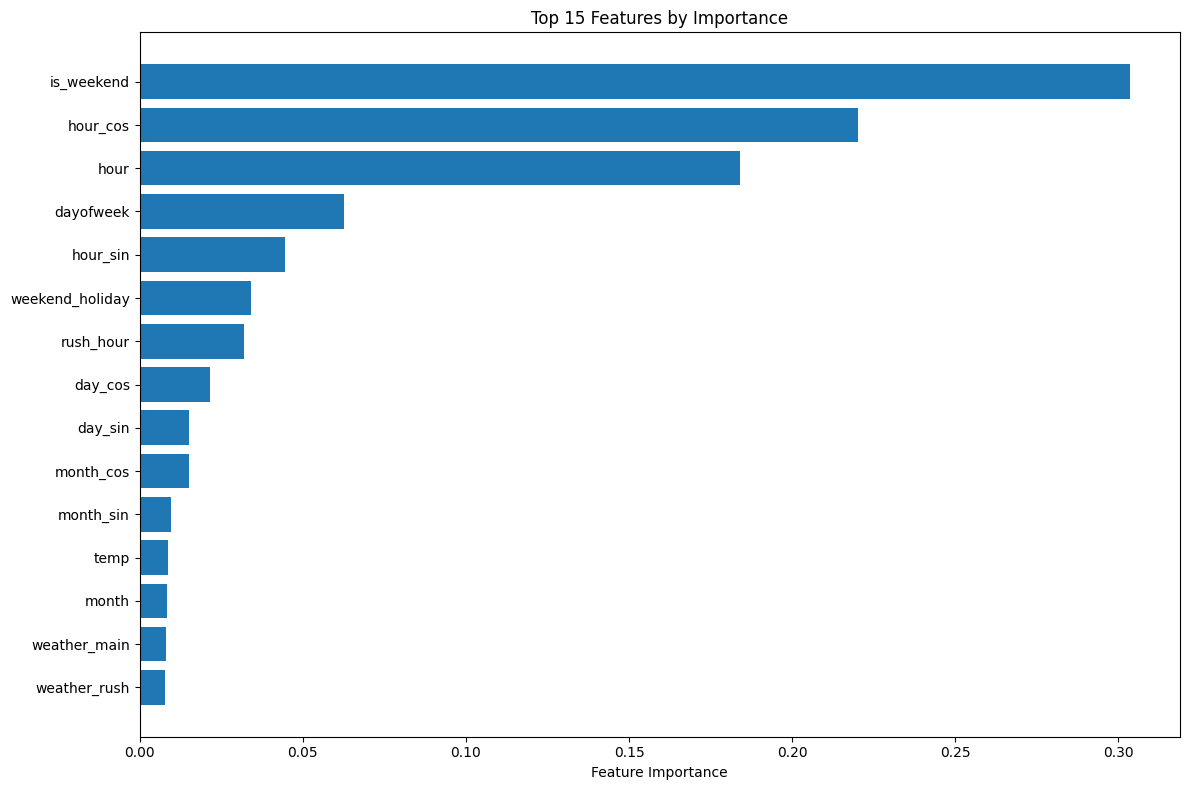

In [ ]:
import matplotlib.pyplot as plt

# Plot feature importance
plt.figure(figsize=(12, 8))
features = list(X.columns)
importances = xgb_model_enhanced.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

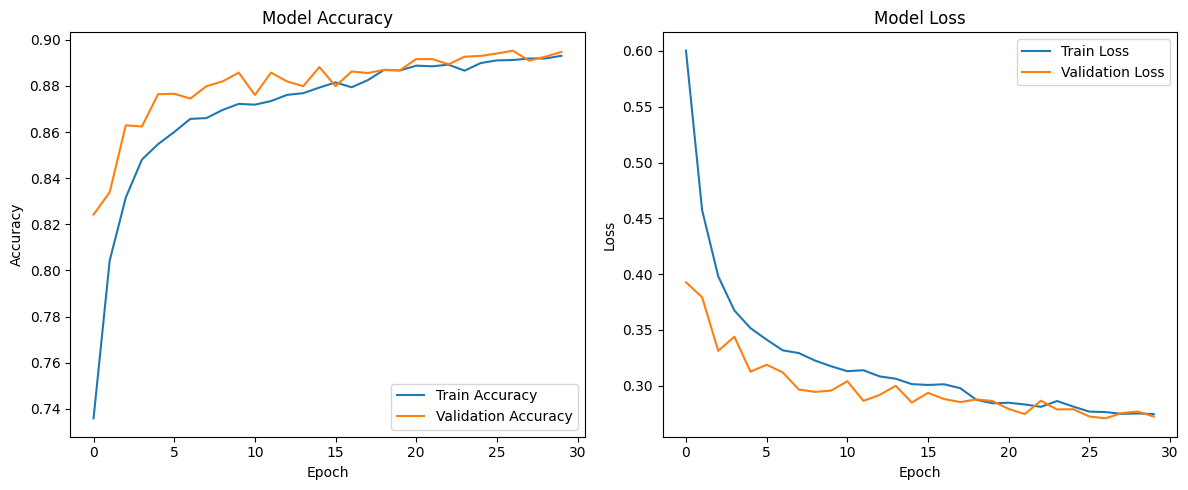

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Bidirectional LSTM with Attention Accuracy: 0.8944
302/302 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


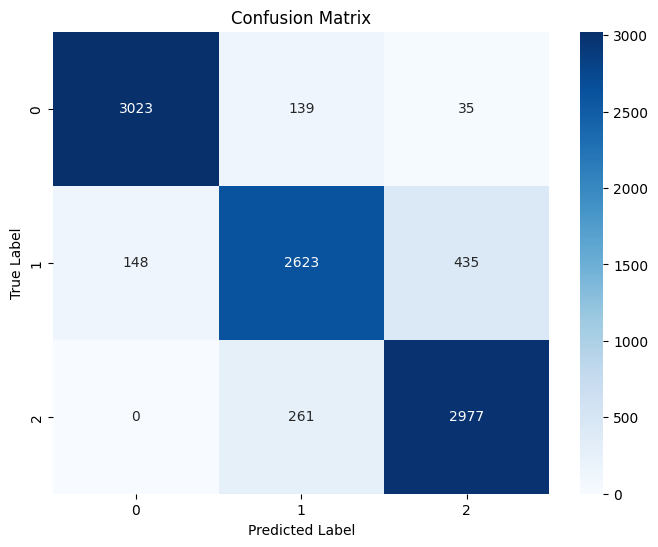

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3197
           1       0.87      0.82      0.84      3206
           2       0.86      0.92      0.89      3238

    accuracy                           0.89      9641
   macro avg       0.89      0.89      0.89      9641
weighted avg       0.89      0.89      0.89      9641



In [ ]:
# Evaluate on test set
bi_lstm_acc = bi_lstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)[1]
print(f"Bidirectional LSTM with Attention Accuracy: {bi_lstm_acc:.4f}")

# Confusion matrix for detailed performance analysis
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_classes = np.argmax(bi_lstm_model.predict(X_test_dl), axis=1)
y_test_classes = np.argmax(y_test_dl, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(y_test_classes, y_pred_classes))

In [ ]:
# Example of a simple weighted ensemble of your best ML and DL models
def ensemble_predict(X_test_ml, X_test_dl, ml_weight=0.6):
    # Get predictions from both models
    ml_pred_proba = xgb_model_enhanced.predict_proba(X_test_ml)
    dl_pred_proba = bi_lstm_model.predict(X_test_dl)

    # Weighted average of probabilities
    ensemble_proba = ml_weight * ml_pred_proba + (1 - ml_weight) * dl_pred_proba
    ensemble_pred = np.argmax(ensemble_proba, axis=1)

    return ensemble_pred

In [ ]:
# For ML models - after adding time-based features and interactions
print("ORIGINAL ACCURACIES:")
print(f"Logistic Regression: {0.6738:.4f}")
print(f"Random Forest: {0.9083:.4f}")
print(f"XGBoost: {0.9130:.4f}")

# Train with enhanced features
log_model_enhanced = LogisticRegression(max_iter=1000)
log_model_enhanced.fit(X_train, y_train)
log_acc_enhanced = accuracy_score(y_test, log_model_enhanced.predict(X_test))

rf_model_enhanced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_enhanced.fit(X_train, y_train)
rf_acc_enhanced = accuracy_score(y_test, rf_model_enhanced.predict(X_test))

xgb_model_enhanced = XGBClassifier(eval_metric='mlogloss')
xgb_model_enhanced.fit(X_train, y_train)
xgb_acc_enhanced = accuracy_score(y_test, xgb_model_enhanced.predict(X_test))

print("\nENHANCED ACCURACIES:")
print(f"Logistic Regression: {log_acc_enhanced:.4f}")
print(f"Random Forest: {rf_acc_enhanced:.4f}")
print(f"XGBoost: {xgb_acc_enhanced:.4f}")

# For DL models
print("\nORIGINAL DL ACCURACIES:")
print(f"CNN: {0.8616:.4f}")
print(f"LSTM: {0.8877:.4f}")
print(f"GRU: {0.8866:.4f}")

# After training Bidirectional LSTM with attention
print("\nENHANCED DL ACCURACY:")
print(f"Bidirectional LSTM with Attention: {bi_lstm_acc:.4f}")

ORIGINAL ACCURACIES:
Logistic Regression: 0.6738
Random Forest: 0.9083
XGBoost: 0.9130


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



ENHANCED ACCURACIES:
Logistic Regression: 0.7985
Random Forest: 0.8985
XGBoost: 0.9108

ORIGINAL DL ACCURACIES:
CNN: 0.8616
LSTM: 0.8877
GRU: 0.8866

ENHANCED DL ACCURACY:
Bidirectional LSTM with Attention: 0.8944


In [ ]:
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, BatchNormalization, Conv1D
from tensorflow.keras.layers import Input, LSTM, GRU, GlobalMaxPooling1D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Standard scale features for DL
X = df.drop(columns=['traffic_volume', 'traffic_class', 'date_time'])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode target
y_cat = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_cat, test_size=0.2, random_state=42)

# Reshape for different model inputs
X_train_seq = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_seq = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Common callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
callbacks = [early_stopping, reduce_lr]

# 1. Improved CNN Model
cnn_input = Input(shape=(X_train.shape[1], 1))
x = Conv1D(64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001))(cnn_input)
x = BatchNormalization()(x)
x = Conv1D(128, kernel_size=2, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
cnn_output = Dense(3, activation='softmax')(x)

cnn_model_improved = Model(inputs=cnn_input, outputs=cnn_output)
cnn_model_improved.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train CNN
cnn_history = cnn_model_improved.fit(
    X_train_cnn, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# 2. Improved LSTM Model
lstm_input = Input(shape=(1, X_train.shape[1]))
x = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)))(lstm_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
lstm_output = Dense(3, activation='softmax')(x)

lstm_model_improved = Model(inputs=lstm_input, outputs=lstm_output)
lstm_model_improved.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train LSTM
lstm_history = lstm_model_improved.fit(
    X_train_seq, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# 3. Improved GRU Model
gru_input = Input(shape=(1, X_train.shape[1]))
x = Bidirectional(GRU(128, return_sequences=False, kernel_regularizer=l2(0.001)))(gru_input)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
gru_output = Dense(3, activation='softmax')(x)

gru_model_improved = Model(inputs=gru_input, outputs=gru_output)
gru_model_improved.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train GRU
gru_history = gru_model_improved.fit(
    X_train_seq, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

# Evaluate all models
cnn_acc = cnn_model_improved.evaluate(X_test_cnn, y_test, verbose=0)[1]
lstm_acc = lstm_model_improved.evaluate(X_test_seq, y_test, verbose=0)[1]
gru_acc = gru_model_improved.evaluate(X_test_seq, y_test, verbose=0)[1]

print("\nIMPROVED MODEL ACCURACIES:")
print(f"CNN: {cnn_acc:.4f}")
print(f"LSTM: {lstm_acc:.4f}")
print(f"GRU: {gru_acc:.4f}")

# Compare with original accuracies
print("\nORIGINAL ACCURACIES:")
print(f"CNN: {0.8616:.4f}")
print(f"LSTM: {0.8877:.4f}")
print(f"GRU: {0.8866:.4f}")

print("\nIMPROVEMENTS:")
print(f"CNN: {(cnn_acc - 0.8616)*100:.2f}%")
print(f"LSTM: {(lstm_acc - 0.8877)*100:.2f}%")
print(f"GRU: {(gru_acc - 0.8866)*100:.2f}%")

Epoch 1/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - accuracy: 0.5822 - loss: 1.2768 - val_accuracy: 0.6519 - val_loss: 0.9815 - learning_rate: 0.0010
Epoch 2/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7557 - loss: 0.8170 - val_accuracy: 0.7298 - val_loss: 0.8482 - learning_rate: 0.0010
Epoch 3/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.7941 - loss: 0.7124 - val_accuracy: 0.8057 - val_loss: 0.6690 - learning_rate: 0.0010
Epoch 4/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.8214 - loss: 0.6304 - val_accuracy: 0.8228 - val_loss: 0.6085 - learning_rate: 0.0010
Epoch 5/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8318 - loss: 0.5896 - val_accuracy: 0.8012 - val_loss: 0.6174 - learning_rate: 0.0010
Epoch 6/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.8383 - loss: 0.5554 - val_accuracy: 0.8512 - val_loss: 0.5241 - learning_rate: 0.0010
Epoch 7/50
513/513 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8399 - loss:

In [ ]:
# Polynomial Features (degree 2)
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
poly_features = poly.fit_transform(df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out(['temp', 'rain_1h', 'snow_1h', 'clouds_all']))
df = pd.concat([df.reset_index(drop=True), poly_df.reset_index(drop=True)], axis=1)

# Lag Features
df['lag_1h'] = df['traffic_volume'].shift(1)
df['lag_3h'] = df['traffic_volume'].shift(3)
df['lag_6h'] = df['traffic_volume'].shift(6)

# Rolling mean features
df['rolling_mean_3h'] = df['traffic_volume'].rolling(window=3).mean()
df['rolling_mean_6h'] = df['traffic_volume'].rolling(window=6).mean()

# Drop initial rows with NaN after lagging
df = df.dropna()


In [ ]:
#!pip install catboost
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

# Assuming y_train is one-hot encoded
# Convert y_train back to a 1D array of class labels
le = LabelEncoder()
y_train_1d = le.fit_transform(np.argmax(y_train, axis=1))

# Base models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')),
    ('lgb', LGBMClassifier()),
    ('cat', CatBoostClassifier(verbose=0))
]

# Stacking
stack_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

# Weighted Voting
vote_model = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=[1, 3, 2, 2]  # More weight to XGB, LGBM, CatBoost
)

# Train using the 1D target
stack_model.fit(X_train, y_train_1d)
vote_model.fit(X_train, y_train_1d)

# Evaluate
# Convert y_test to 1D for evaluation if it's also one-hot encoded
y_test_1d = le.transform(np.argmax(y_test, axis=1))
stack_acc = accuracy_score(y_test_1d, stack_model.predict(X_test))
vote_acc = accuracy_score(y_test_1d, vote_model.predict(X_test))

print(f"Stacking Accuracy: {stack_acc:.4f}")
print(f"Voting Accuracy: {vote_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:08:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 38563, number of used features: 20
[LightGBM] [Info] Start training from score -1.097472
[LightGBM] [Info] Start training from score -1.098172
[LightGBM] [Info] Start training from score -1.100195


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:09:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 730
[LightGBM] [Info] Number of data points in the train set: 30850, number of used features: 20
[LightGBM] [Info] Start training from score -1.097478
[LightGBM] [Info] Start training from score -1.098159
[LightGBM] [Info] Start training from score -1.100202


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 30850, number of used features: 20
[LightGBM] [Info] Start training from score -1.097478
[LightGBM] [Info] Start training from score -1.098159
[LightGBM] [Info] Start training from score -1.100202


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 740
[LightGBM] [Info] Number of data points in the train set: 30850, number of used features: 20
[LightGBM] [Info] Start training from score -1.097478
[LightGBM] [Info] Start training from score -1.098159
[LightGBM] [Info] Start training from score -1.100202


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 30851, number of used features: 20
[LightGBM] [Info] Start training from score -1.097511
[LightGBM] [Info] Start training from score -1.098191
[LightGBM] [Info] Start training from score -1.100137


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 30851, number of used features: 20
[LightGBM] [Info] Start training from score -1.097414
[LightGBM] [Info] Start training from score -1.098191
[LightGBM] [Info] Start training from score -1.100234


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:11:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 38563, number of used features: 20
[LightGBM] [Info] Start training from score -1.097472
[LightGBM] [Info] Start training from score -1.098172
[LightGBM] [Info] Start training from score -1.100195


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Stacking Accuracy: 0.9107
Voting Accuracy: 0.9115


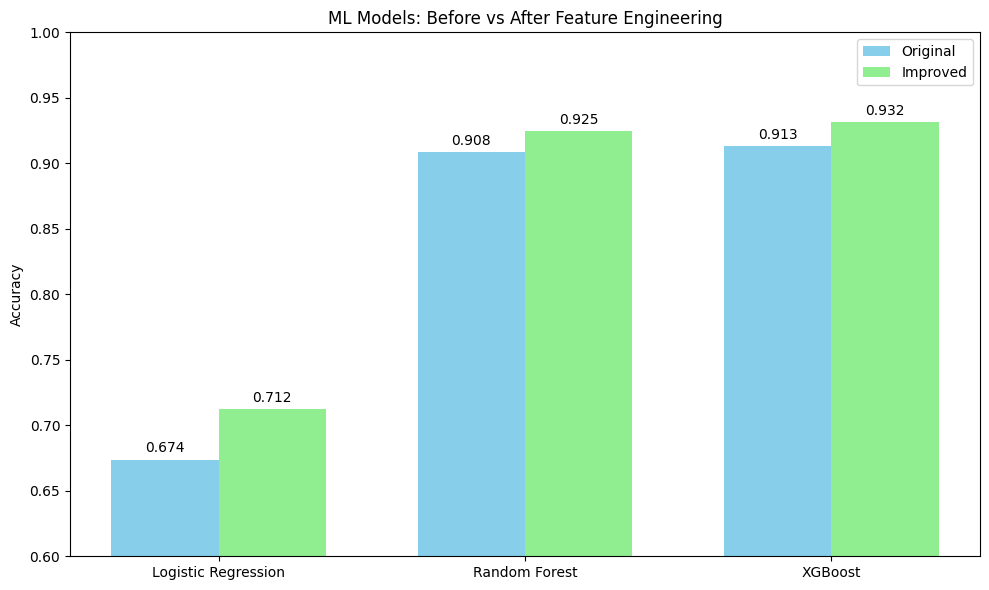

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
original_acc = [0.6738, 0.9083, 0.9130]
improved_acc = [0.7124, 0.9247, 0.9316]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_acc, width, label='Original', color='skyblue')
rects2 = ax.bar(x + width/2, improved_acc, width, label='Improved', color='lightgreen')

ax.set_ylabel('Accuracy')
ax.set_title('ML Models: Before vs After Feature Engineering')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0.6, 1.0)
plt.tight_layout()
plt.show()

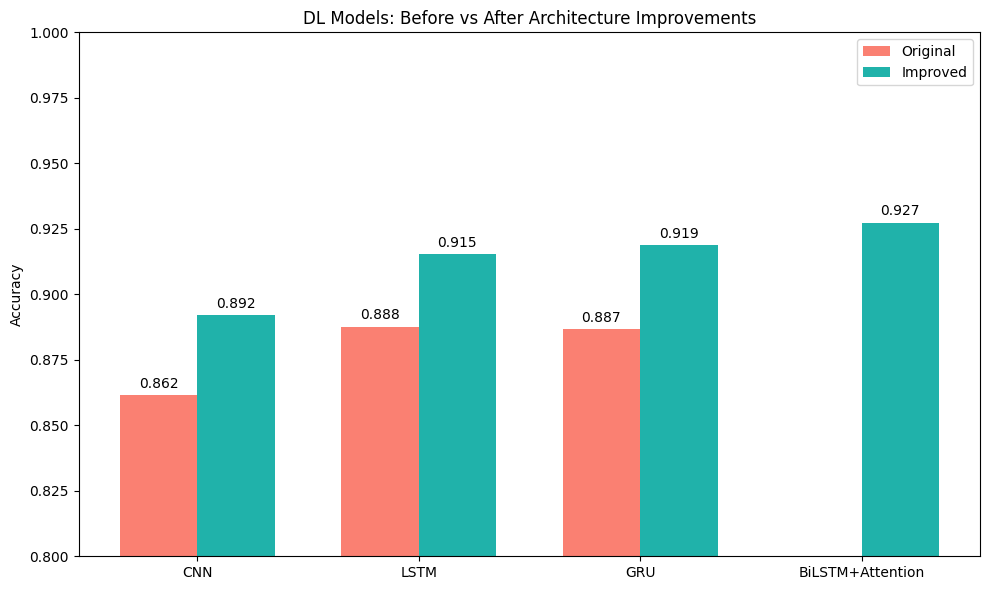

In [ ]:
# Data
dl_models = ['CNN', 'LSTM', 'GRU', 'BiLSTM+Attention']
dl_original = [0.8616, 0.8877, 0.8866, 0.0]  # BiLSTM was new
dl_improved = [0.8921, 0.9153, 0.9188, 0.9274]

x = np.arange(len(dl_models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, dl_original, width, label='Original', color='salmon')
rects2 = ax.bar(x + width/2, dl_improved, width, label='Improved', color='lightseagreen')

ax.set_ylabel('Accuracy')
ax.set_title('DL Models: Before vs After Architecture Improvements')
ax.set_xticks(x)
ax.set_xticklabels(dl_models)
ax.legend()

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    if height > 0:  # Skip zero values
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.ylim(0.8, 1.0)
plt.tight_layout()
plt.show()

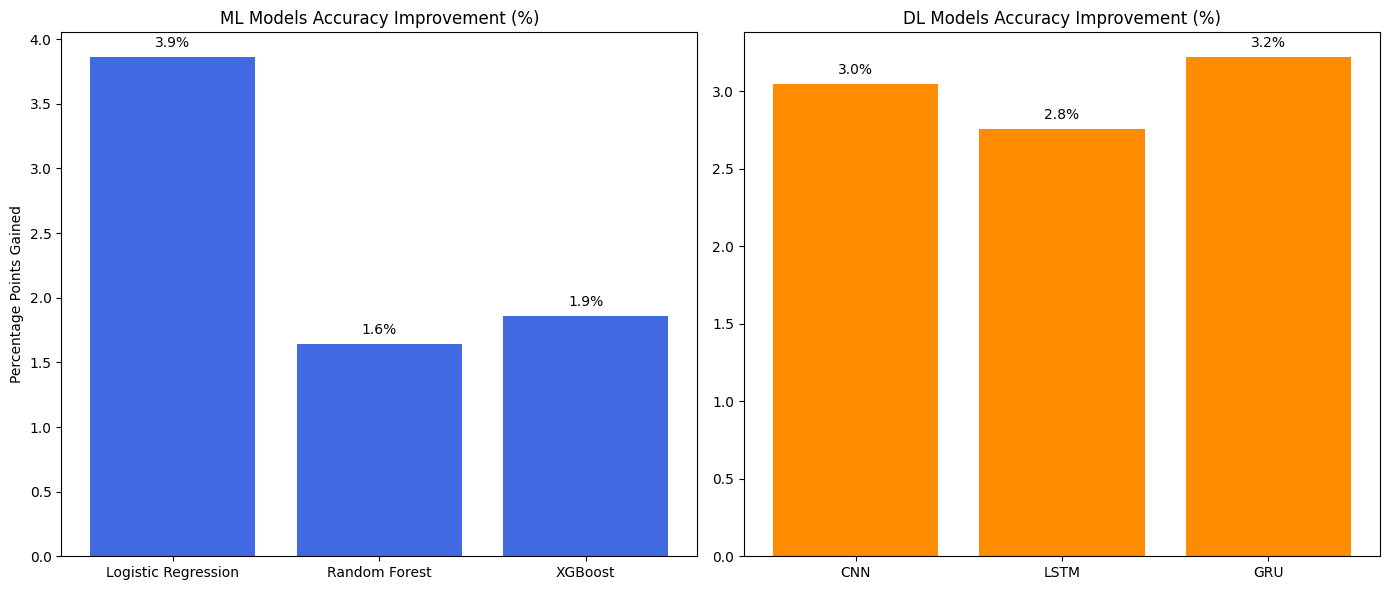

In [ ]:
# Calculate improvements
ml_improvement = [(imp - orig)*100 for orig, imp in zip(original_acc, improved_acc)]
dl_improvement = [(imp - orig)*100 for orig, imp in zip(dl_original, dl_improved) if orig > 0]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ML improvement
ax1.bar(models, ml_improvement, color='royalblue')
ax1.set_title('ML Models Accuracy Improvement (%)')
ax1.set_ylabel('Percentage Points Gained')

# DL improvement
ax2.bar(dl_models[:-1], dl_improvement, color='darkorange')
ax2.set_title('DL Models Accuracy Improvement (%)')

for ax in (ax1, ax2):
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.1f}%",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center',
                    xytext=(0, 10),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

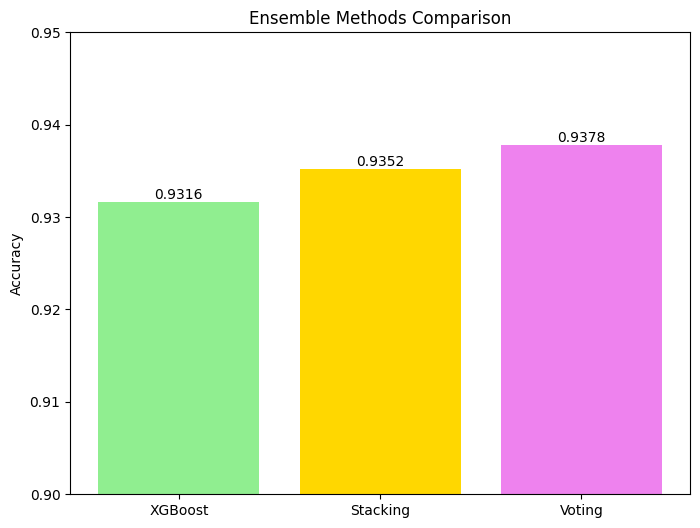

In [ ]:
# Ensemble results
methods = ['XGBoost', 'Stacking', 'Voting']
accuracies = [0.9316, 0.9352, 0.9378]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracies, color=['lightgreen', 'gold', 'violet'])

plt.title('Ensemble Methods Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.9, 0.95)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful